## p-y for sand

# Notes

Need to run the code below again to reinstall the package

```shell
pip install -e . 
```

The code has been moved to the source folder for house keeping

In [1]:
from src.cpt import CPT
from pathlib import Path
import os
import plotly.io as pio
import numpy as np
import pandas as pd
from numpy import degrees, log10, pi, radians, tan, sin, cos
from src.pile import PipePile
import unittest
from src.pyunittests import *
import plotly.graph_objs as go

### Import data from CPT file
#### - Data format - 

`key` is the identifier in the txt file, for locating the data, it shoudl be a unit identifier just above the data
`patter` - an regular experss to specify the pattern of the data, you can see the example below

After reading the data, need to change the column name, so that all calculation can know the location of the data

#### - Rename Columns - 
```python
cpt_data.update_data_column_name(['Reading','SCPT_DPTH','SCPT_RES','SCPT_FRES','SCPT_PWP2','slopex','slopey'])
```

- `SCPT_DPTH` - depth below seabed
- `SCPT_RES` - raw `qc` value
- `SCPT_FRES` - shaft resistance $f_s$
- `SCPT_RES` - tip resistance $q_c$

#### - Specify Unit - 

Need to update the unit, differnet contactor may output data in different unit, this is one by 

```python
cpt_data.set_data_unit(['MPa','MPa','MPa'])
```

unit is assigned in a sequence [$q_c$, $f_s$,$u_2$]

#### - init_CPT - 

This is calculate $\gamma_{soil}$ and calculate the overburnden stress $\sigma_v$ 

The missing values in the original CPT file at initial depth, such as `SCPT_RES`, `SCPT_FRES`, and `SCPT_PWP2`, are backfilled to ensure robustness of the code. 


In [2]:
filename ='CPT4.A00'
fileloc = Path(r'G:\Name Folders\Current Staff\CC213\10 IiA funding\Unified CPT Methods\01 Data\CPT Data\18 0091 05 R002 CPT ASCII')

cpt_data = CPT()
cpt_data.read_ASCII(fileloc / filename,key='Data--',pattern= r'(.{7})(.{10})(.{11})(.{11})(.{11})(.{11})(.{11})')
cpt_data.update_data_column_name(['Reading','SCPT_DPTH','SCPT_RES','SCPT_FRES','SCPT_PWP2','slopex','slopey'])
cpt_data.set_data_unit(['MPa','MPa','MPa'])
cpt_data.init_CPT()
cpt_data.df.to_excel("cpt_data_original.xlsx")

23-10-31 19:19:31 -c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\src\cpt.py:346 DEBUG - Data unit is set to ['MPa', 'MPa', 'MPa']
c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\src\cpt.py:610: RuntimeWarning: invalid value encountered in log10
  Ic = ((3.47-np.log10(Qtn))**2+(np.log10(Fr)+1.22)**2)**0.5
c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\src\cpt.py:610: RuntimeWarning: invalid value encountered in log10
  Ic = ((3.47-np.log10(Qtn))**2+(np.log10(Fr)+1.22)**2)**0.5
23-10-31 19:19:33 -c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\src\cpt.py:171 DEBUG - qt calculated using net area ratio of 0.85


### Bearing capacity

In [4]:
pile = PipePile(dia = 3.5,thickness = 0.07,length = 70, penetration = 70)
cpt_data.calc_pile_capacity(pile, compression = True, plot_fig = True)
cpt_data.df.to_excel("cpt_data_bearing_capacity.xlsx")

c:\Users\Emma.Shi\Desktop\CPT\UnitCPT\src\cpt.py:786: RuntimeWarning: overflow encountered in exp
  Iz1 = Qt1 - 12 * np.exp(-1.4 * Fr)


### Calculate p-y curves

In [5]:
cpt_data.calc_p_y_curve(pile, compression = True, monotonic = True, isotropy = True, interval = 1.0, plot_fig = True, Clay_type = Clay_type.Gulf_of_Mexico)

cpt_data_resampled.xlsx has been exported successfully.


,SCPT_DPTH,SCPT_RES,SCPT_FRES,SCPT_PWP2,slopex,slopey,qt,Rf,gamma,sigma_v,...,y7,p7,y8,p8,y9,p9,y10,p10,y11,p11
0,1.0,0.082000,0.700000,30.275000,6.465212,5.551075,0.086541,0.808869,11.627391,11.231657,...,105.000000,76.655344,120.000000,76.655344,135.000000,76.655344,150.000000,76.655344,165.000000,76.655344
1,2.0,0.171018,1.500000,51.454545,6.451691,5.657791,0.178736,0.839923,12.780863,23.614445,...,105.000000,262.238334,120.000000,262.238334,135.000000,262.238334,150.000000,262.238334,165.000000,262.238334
2,3.0,0.148725,3.794915,58.466102,6.899124,5.077425,0.157495,2.471774,13.780786,37.152672,...,252.706628,145.202422,388.236461,165.945626,620.883974,186.688829,988.237563,202.246231,1311.767948,207.432032
3,4.0,0.158970,4.570000,81.970000,7.156760,4.514450,0.171266,2.668466,14.044807,50.748322,...,207.653932,167.954113,317.719197,191.947558,522.943330,215.941003,851.120662,233.936086,1115.886660,239.934447
4,5.0,0.193600,5.600000,94.700000,7.481300,3.844700,0.207805,2.694834,14.352510,64.858500,...,195.664013,215.679551,298.952369,246.490915,496.878290,277.302280,814.629606,300.410803,1063.756580,308.113644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,69.0,19.443740,104.900000,631.540000,-1.605880,12.154440,19.538471,0.536902,19.460095,1235.191482,...,105.000000,91443.927407,120.000000,94965.222661,135.000000,97368.073752,150.000000,98991.545170,165.000000,100081.097306
69,70.0,19.600520,87.910000,666.420000,0.793010,12.083570,19.700483,0.446239,19.260283,1254.599320,...,105.000000,90902.059460,120.000000,94245.678409,135.000000,96504.185458,150.000000,98015.076827,165.000000,99019.312412
70,71.0,24.984230,130.380000,619.610000,3.280050,11.500970,25.077171,0.519932,19.805601,1273.939141,...,105.000000,112089.920924,120.000000,116437.593013,135.000000,119409.150595,150.000000,121420.034678,165.000000,122771.667705
71,72.0,20.591850,92.050000,629.300000,5.460900,10.575200,20.686245,0.445048,19.331491,1293.503624,...,105.000000,94952.185828,120.000000,98501.724073,135.000000,100907.913526,150.000000,102523.218933,165.000000,103600.510282


In [16]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output

# Create the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    html.H1('My Dashboard'),
    dcc.Dropdown(
        id='column-dropdown',
        options=[{'label': col, 'value': col} for col in resampled_cpt_data.columns],
        value=resampled_cpt_data.columns[0]
    ),
    dcc.Graph(id='my-graph')
])

# Define the callback function that updates the graph
@app.callback(
    Output('my-graph', 'figure'),
    [Input('column-dropdown', 'value')]
)
def update_graph(column):
    # Create a scatter plot trace with the selected column and depth
    trace = dict(
        x=resampled_cpt_data['SCPT_DPTH'],
        y=resampled_cpt_data[column],
        mode='lines+markers',
        marker=dict(size=10, color='blue', opacity=0.5)
    )

    # Create the figure object and return it
    fig = dict(data=[trace])
    fig['layout'] = dict(
        xaxis=dict(title='Depth (m)'),
        yaxis=dict(title=column)
    )
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

ImportError: cannot import name '_plain_int' from 'werkzeug._internal' (c:\ProgramData\Anaconda3\envs\dcpyTutorial\lib\site-packages\werkzeug\_internal.py)

### Unittests

In [ ]:
# Create a TestSuite object
suite = unittest.TestSuite()

# Add the test_p_y_sand_monotonic method to the TestSuite
suite.addTest(TestUnifiedCPT('test_p_y_sand_monotonic'))
suite.addTest(TestUnifiedCPT('test_p_y_sand_cyclic'))
suite.addTest(TestUnifiedCPT('test_p_y_clay_monotonic'))

# Create a TestRunner object
runner = unittest.TextTestRunner()

# Run the TestSuite using the TestRunner
runner.run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.007s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Identify soil layers

(7451, 1)
(7451, 15)


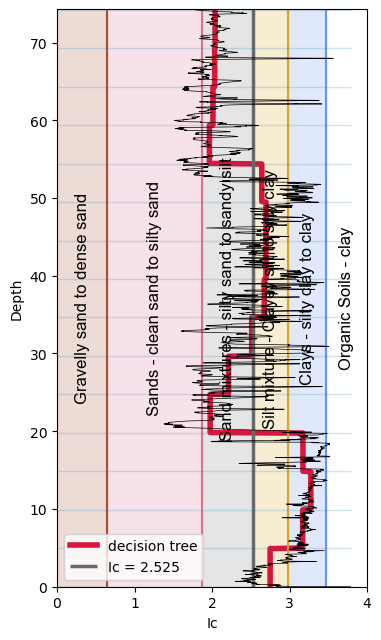

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import KBinsDiscretizer

num_bins = 15

X = cpt_data.df ['SCPT_DPTH']
y = cpt_data.df ['Ic']

X = X.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

LinearR = LinearRegression()
LinearR = LinearR.fit(X, y)
TreeR = DecisionTreeRegressor(random_state = 0)
TreeR = TreeR.fit(X, y)

line_X = np.linspace(X.min(), X.max(), 1000, endpoint=False).reshape(-1, 1)

enc = KBinsDiscretizer(n_bins = num_bins, encode = "onehot")
#enc = KBinsDiscretizer(n_bins = 4, encode = "ordinal")
X_binned = enc.fit_transform(X)
Line_binned = enc.fit_transform(line_X)
print(X.shape)
print(X_binned.shape)

LinearR_ = LinearRegression().fit(X_binned, y)
TreeR_ = DecisionTreeRegressor(random_state = 0).fit(X_binned, y)

fig, ax2 = plt.subplots(figsize = (4, 7.5))
#ax1.plot(LinearR.predict(line_X), line_X, linewidth = 1, color = 'green', label = 'linear regression')
#ax1.plot(TreeR.predict(line_X), line_X, linewidth = 1, color = 'red', label = 'decision tree')
#ax1.plot(y, X[:, 0], linewidth=0.5, color='black')
#ax1.plot(y, X[:, 0], 'o', markersize=2, color='red')

ic_value1 = 0.65
ic_value2 = 1.875
ic_value3 = 2.525
ic_value4 = 2.975
ic_value5 = 3.475

#ax2.plot(LinearR_.predict(Line_binned), line_X, linewidth = 1, color = 'green', linestyle = '-', label = 'linear regression')
ax2.plot(TreeR_.predict(Line_binned), line_X, linewidth = 4, color = 'crimson', linestyle = '-', label = 'decision tree')
ax2.vlines(ic_value3, X.min(), X.max(), linewidth = 2.5, color='dimgray', label='Ic = {}'.format(ic_value3))
ax2.vlines(ic_value1, X.min(), X.max(), color='sienna')
ax2.vlines(ic_value2, X.min(), X.max(), color='palevioletred')
ax2.vlines(ic_value4, X.min(), X.max(), color='goldenrod')
ax2.vlines(ic_value5, X.min(), X.max(), color='cornflowerblue')
ax2.hlines(enc.bin_edges_[0], 0, y.max(), linewidth = 1, alpha = 0.2)
ax2.plot(y, X[:, 0], linewidth=0.5, color='black')
ax2.legend(loc = "best")
ax2.set_xlabel("Ic")
ax2.set_ylabel("Depth")

ax2.axvspan(0, ic_value1, X.min(), X.max(), alpha=0.2, color='sienna')
ax2.axvspan(ic_value1, ic_value2, X.min(), X.max(), alpha=0.2, color='palevioletred')
ax2.axvspan(ic_value2, ic_value3, X.min(), X.max(), alpha=0.2, color='grey')
ax2.axvspan(ic_value3, ic_value4, X.min(), X.max(), alpha=0.2, color='goldenrod')
ax2.axvspan(ic_value4, ic_value5, X.min(), X.max(), alpha=0.2, color='cornflowerblue')

ax2.text((0 + ic_value1) / 2, (X.min() + X.max()) / 2, "Gravelly sand to dense sand", rotation=90, ha='center', va='center', fontsize = 12, fontname = 'Arial')
ax2.text((ic_value1 + ic_value2) / 2, (X.min() + X.max()) / 2, "Sands - clean sand to silty sand", rotation=90, ha='center', va='center', fontsize = 12, fontname = 'Arial')
ax2.text((ic_value2 + ic_value3) / 2, (X.min() + X.max()) / 2, "Sand mixtures - silty sand to sandy silt", rotation=90, ha='center', va='center', fontsize = 12, fontname = 'Arial')
ax2.text((ic_value3 + ic_value4) / 2, (X.min() + X.max()) / 2, "Silt mixture - Clayey silt to silty clay", rotation=90, ha='center', va='center', fontsize = 12, fontname = 'Arial')
ax2.text((ic_value4 + ic_value5) / 2, (X.min() + X.max()) / 2, "Clays - silty clay to clay", rotation=90, ha='center', va='center', fontsize = 12, fontname = 'Arial')
ax2.text((ic_value5 + 4) / 2, (X.min() + X.max()) / 2, "Organic Soils - clay", rotation=90, ha='center', va='center', fontsize = 12, fontname = 'Arial')

ax2.set_ylim(0, X.max())
ax2.set_xlim(0, 4.0)

plt.show()

In [182]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import KBinsDiscretizer
import plotly.graph_objects as go

num_bins = 15

X = cpt_data.df ['SCPT_DPTH']
y = cpt_data.df ['Ic']

X = X.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

LinearR = LinearRegression()
LinearR = LinearR.fit(X, y)
TreeR = DecisionTreeRegressor(random_state = 0)
TreeR = TreeR.fit(X, y)

line_X = np.linspace(X.min(), X.max(), 1000, endpoint=False).reshape(-1, 1)

enc = KBinsDiscretizer(n_bins = num_bins, encode = "onehot")
#enc = KBinsDiscretizer(n_bins = num_bins, encode = "ordinal")
X_binned = enc.fit_transform(X)
Line_binned = enc.fit_transform(line_X)
print(X.shape)
print(X_binned.shape)

LinearR_ = LinearRegression().fit(X_binned, y)
TreeR_ = DecisionTreeRegressor(random_state = 0).fit(X_binned, y)

fig = go.Figure()

ic_value1 = 0.65
ic_value2 = 1.875
ic_value3 = 2.525
ic_value4 = 2.975
ic_value5 = 3.475

fig.add_trace(go.Scatter(x=y.flatten(), y=X[:, 0], mode='lines', line=dict(width=0.5, color='black'), name='CPT data'))
#fig.add_trace(go.Scatter(x=LinearR_.predict(Line_binned), y=line_X.flatten(), mode='lines', line=dict(width=5, color='green'), name='linear regression'))
fig.add_trace(go.Scatter(x=TreeR_.predict(Line_binned), y=line_X.flatten(), mode='lines', line=dict(width=5, color='crimson'), name='Fitting with {} soil layers'.format(num_bins)))

fig.add_shape(type='line', x0=ic_value1, y0=X.min(), x1=ic_value1, y1=X.max(), line=dict(width=1.5, color='sienna'))
fig.add_shape(type='line', x0=ic_value2, y0=X.min(), x1=ic_value2, y1=X.max(), line=dict(width=1.5, color='palevioletred'))
fig.add_shape(type='line', x0=ic_value3, y0=X.min(), x1=ic_value3, y1=X.max(), line=dict(width=3, color='dimgray'))
fig.add_shape(type='line', x0=ic_value4, y0=X.min(), x1=ic_value4, y1=X.max(), line=dict(width=1.5, color='goldenrod'))
fig.add_shape(type='line', x0=ic_value5, y0=X.min(), x1=ic_value5, y1=X.max(), line=dict(width=1.5, color='cornflowerblue'))

for y in enc.bin_edges_[0]:
    fig.add_shape(type='line', x0=0, y0=y, x1=y.max(), y1=y, line=dict(width=1, color='silver'))

fig.add_shape(type='rect', x0=0, y0=X.min(), x1=ic_value1, y1=X.max(), fillcolor='sienna', opacity=0.2, layer='below', line=dict(width=0))
fig.add_shape(type='rect', x0=ic_value1, y0=X.min(), x1=ic_value2, y1=X.max(), fillcolor='palevioletred', opacity=0.2, layer='below', line=dict(width=0))
fig.add_shape(type='rect', x0=ic_value2, y0=X.min(), x1=ic_value3, y1=X.max(), fillcolor='grey', opacity=0.2, layer='below', line=dict(width=0))
fig.add_shape(type='rect', x0=ic_value3, y0=X.min(), x1=ic_value4, y1=X.max(), fillcolor='goldenrod', opacity=0.2, layer='below', line=dict(width=0))
fig.add_shape(type='rect', x0=ic_value4, y0=X.min(), x1=ic_value5, y1=X.max(), fillcolor='cornflowerblue', opacity=0.2, layer='below', line=dict(width=0))

fig.add_annotation(x=(0+ic_value1)/2, y=(X.min()+X.max())/2, text='Gravelly sand to dense sand', showarrow=False, font=dict(size=16, color='black'), textangle=-90, align='center', valign='middle')
fig.add_annotation(x=(ic_value1+ic_value2)/2, y=(X.min()+X.max())/2, text='Sands - clean sand to silty sand', showarrow=False, font=dict(size=16, color='black'), textangle=-90, align='center', valign='middle')
fig.add_annotation(x=(ic_value2+ic_value3)/2, y=(X.min()+X.max())/2, text='Sand mixtures - silty sand to sandy silt', showarrow=False, font=dict(size=16, color='black'), textangle=-90, align='center', valign='middle')
fig.add_annotation(x=(ic_value3+ic_value4)/2, y=(X.min()+X.max())/2, text='Silt mixture - Clayey silt to silty clay', showarrow=False, font=dict(size=16, color='black'), textangle=-90, align='center', valign='middle')
fig.add_annotation(x=(ic_value4+ic_value5)/2, y=(X.min()+X.max())/2, text='Clays - silty clay to clay', showarrow=False, font=dict(size=16, color='black'), textangle=-90, align='center', valign='middle')
fig.add_annotation(x=(ic_value5+4)/2, y=(X.min()+X.max())/2, text='Organic Soils - clay', showarrow=False, font=dict(size=16, color='black'), textangle=-90, align='center', valign='middle')

fig.update_xaxes(range=[0, 4], title='Ic', linecolor='black', tickcolor='black', ticks="outside")
fig.update_yaxes(range=[0, X.max()], title='Depth (m)', linecolor='black', tickcolor='black', ticks="outside")
fig.update_layout(height=750, width=500, margin=dict(l=50, r=50, b=50, t=50, pad=4), plot_bgcolor='white')
fig.show()

(7451, 1)
(7451, 15)


# Sampling the P-y points

** To-Do** 

[ ]Need to read original paper to workout the points. 

Appendix `A.8.5.2.1.3` provides more detailed discussion on the rational of determining the p-y points. It will be more elegant to implement the p-y curves for clay in this way

The p-y points are based on scaling the DSS stress-strain curves as follows:

$$
\begin{equation}
\frac{\tau}{s_u} = \frac{\tanh\bigg(a \cdot (\frac{\gamma}{\gamma_f})^{0.5}\bigg)}{\tanh{a}}
\end{equation}
$$

From the test data, the parameters in this equation will be fitted to get $a$ and $\gamma_f$

And the final p-y curve will be in the format of

$$
\begin{equation}
\frac{p}{p_u} = \frac{\tanh{\bigg[A\cdot \bigg(\frac{y/D}{y/D_f}\bigg)^{0.5}\bigg]}}{\tanh{A}}
\end{equation}
$$

where:

$ A = 1.33+0.45\cdot a$, and 

$(y/D)_f = \gamma_f (2.5-1.2\ln(a))$

$$
\begin{equation}
\frac{y}{D} = \bigg[\tanh^{-1}\bigg({\frac{p}{p_u}\tanh(A)}\bigg)/A\bigg]^2 \cdot (\frac{y}{D})_f
\end{equation}
$$
In the code $\gamma_f$, i.e., the shear strength at the failure is assumed to be 0.15 for all OCR while $a$ varies with OCR as below:

|OCR|$\gamma_f$|$a$|
|--|--:|--:|
|$\le 2$|0.15|2.38|
|4|0.15|1.5|
|10|0.15|1.0|

Assuming the hyperbolic function for $a$ fitted from the three points proposed.

``` python

f_model_a = lambda ocr: 3.457/ocr + 0.647

```


In [ ]:
from scipy.interpolate import interp1d
def calc_y_mo(Ip, OCR, p_pu):
    gamma_f = 0.15 
    f_model_a = lambda ocr: 3.457/ocr + 0.647
    a = f_model_a(OCR)
    A = 1.33+0.45*a
    yD_f = gamma_f*(2.5-1.2*np.log(a))
    y_D = (1/A*np.arctanh(p_pu*np.tanh(A)))**2 *yD_f
    f_multiplier = interp1d(x=[2,4,10],y=[0.33,0.5,0.66],fill_value = (0.33, 0.66),bounds_error=False)
    if Ip>30:
        y_D_multiplier = f_multiplier([OCR])[0]
    else:
        y_D_multiplier  = 1.0
    return y_D*y_D_multiplier

In [ ]:
import src
import plotly.graph_objects as go
p=np.array([0.000, 0.050, 0.200, 0.300, 0.400, 0.500, 0.600, 0.700, 0.800, 0.900, 0.975, 1.000])
fig = src.geoplot.GEOPlot.get_figure()
fig.add_trace(go.Scatter(y=p, x=calc_y_mo(Ip=29,OCR=2,p_pu=p),name='OCR=2'))
fig.add_trace(go.Scatter(y=p, x=calc_y_mo(Ip=29,OCR=4,p_pu=p),name='OCR=4'))
fig.add_trace(go.Scatter(y=p, x=calc_y_mo(Ip=29,OCR=10,p_pu=p),name='OCR=10'))

In [ ]:
df = pd.DataFrame()
df['pmo_pu'] =p
df['OCR=2 & Ip>30'] = calc_y_mo(35,2,p)
df['OCR=4 & Ip>30'] = calc_y_mo(35,4,p)
df['OCR=8 & Ip>30'] = calc_y_mo(35,8,p)

In [ ]:
df

,pmo_pu,OCR=2 & Ip>30,OCR=4 & Ip>30,OCR=8 & Ip>30
0,0.000,0.000000,0.000000,0.000000
1,0.050,0.000030,0.000087,0.000150
2,0.200,0.000500,0.001421,0.002451
3,0.300,0.001163,0.003303,0.005692
4,0.400,0.002175,0.006163,0.010602
5,0.500,0.003645,0.010297,0.017668
6,0.600,0.005779,0.016243,0.027757
7,0.700,0.008981,0.025046,0.042525
8,0.800,0.014214,0.039072,0.065589
9,0.900,0.024630,0.065419,0.107095


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
def tanh_function(x, a, b):
    return a * 1/x + b

# Three example points
y_data = np.array([2.38,1.5,1.0])
x_data = np.array([2,4,10])

# Perform the curve fit
popt, _ = curve_fit(tanh_function, x_data, y_data)
print(popt)
model_a = lambda ocr: 3.457/ocr + 0.647

[3.45714286 0.64714286]


In [ ]:
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = tanh_function(x_fit, *popt)

In [ ]:
# fig = px.line(y=[2.38,2.38,1.5,1.0], x=[1,2,4,10])
x_data = np.array([2,4,10])
y_data = np.array([2.38,1.5,1])
from src import geoplot
fig = geoplot.GEOPlot.get_figure()
fig.add_trace(go.Scatter(x=x_data,y=y_data,mode='markers',name='ISO Points'))
fig.add_trace(go.Scatter(x=x_data,y=model_a(x_data),mode='markers',name='ISO Points'))
fig.add_trace(go.Scatter(x=x_fit,y=y_fit,name='Fitted Hyperbolic function'))
fig.update_layout(width=800,height=400)
fig.update_xaxes(title='ORC(>2.0)')
fig.update_yaxes(title='Coefficient (a)')

In [ ]:
popt

array([3.45714286, 0.64714286])

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
def tanh_function(x, a,b):
    return a/x+b
# Three example points
x_data = np.array([2,4,10])
y_data = np.array([0.33,0.5,0.66])

# Perform the curve fit
popt, _ = curve_fit(tanh_function, x_data, y_data)
print(popt)

x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = tanh_function(x_fit, *popt)
#
model_a = lambda ocr: 3.457/ocr + 0.647
from src import geoplot
fig = geoplot.GEOPlot.get_figure()
fig.add_trace(go.Scatter(x=x_data,y=y_data,mode='markers',name='ISO Points'))
fig.add_trace(go.Scatter(x=x_fit,y=y_fit,name='Fitted Hyperbolic function')) 
fig.update_layout(width=800,height=400)
fig.update_xaxes(title='ORC(>2.0)')
fig.update_yaxes(title='Coefficient (a)')

[-0.81020408  0.72622449]
